In [1]:
using Plots, LaTeXStrings, Optim, SpecialFunctions, Random, Distributions, Dierckx, NLopt, ForwardDiff, LinearAlgebra 
using DifferentialEquations, Interpolations, Roots
gr(); #Load packages

In [2]:
function Stochastic(LX,LY,t1,A0,PM,ρ) #Stochastic model
Q=sum(A0)
T=Int(t1)
AA=zeros(LX,LY)
NumAgent=zeros(LX)
NumAgent0=zeros(LX)
AAtemp=copy(A0)

pos = [(0, 0) for _ in 1:Q]
pos0 = [(0, 0) for _ in 1:Q]    
    
for i in 1:LX
     for j in 1:LY
        NumAgent0[i]=NumAgent0[i]+AAtemp[i,j]
    end
end
count = 0    
for i in 1:LX
    for j in 1:LY
        if A0[i,j] > 0
        count +=1
        pos0[count] = (i,j)
        end
    end
end

    
for kk in 1:T
        count = 0
        while count  < Q
            II =rand(1:LX)
            JJ=rand(1:LY)
if AAtemp[II,JJ] > 0.0 && II>1 && II<LX && JJ > 1 && JJ < LY 
            count=count+1
            R =rand(1)
            S=rand(1)
                if AAtemp[II-1,JJ] == 0.0 && R[1] > 0 && R[1]<=(1-ρ)/4 && S[1] <=PM
                AAtemp[II,JJ]=0.0
                AAtemp[II-1,JJ]=1.0
                elseif AAtemp[II+1,JJ] == 0.0 && R[1] > (1-ρ)/4 && R[1]<=2/4  && S[1] <=PM
                AAtemp[II,JJ]=0.0
                AAtemp[II+1,JJ]=1.0
                elseif AAtemp[II,JJ-1] == 0.0 && R[1] > 2/4 && R[1]<=3/4  && S[1] <=PM
                AAtemp[II,JJ]=0.0
                AAtemp[II,JJ-1]=1.0
                elseif AAtemp[II,JJ+1] == 0.0 && R[1] > 3/4 && R[1]<=4/4  && S[1] <=PM
                AAtemp[II,JJ]=0.0
                AAtemp[II,JJ+1]=1.0
                end

                elseif AAtemp[II,JJ] > 0.0 && II>1 && II<LX && JJ == 1 
                    count=count+1
                    R =rand(1)
                    S=rand(1)
                        if AAtemp[II-1,JJ] == 0.0 && R[1] > 0 && R[1]<=(1-ρ)/4  && S[1] <=PM
                        AAtemp[II,JJ]=0.0
                        AAtemp[II-1,JJ]=1.0
                        elseif AAtemp[II+1,JJ] == 0.0 && R[1] > (1-ρ)/4 && R[1]<=2/4 && S[1] <=PM
                        AAtemp[II,JJ]=0.0
                        AAtemp[II+1,JJ]=1.0
                        elseif AAtemp[II,JJ+1] == 0.0 && R[1] > 3/4 && R[1]<=4/4 && S[1] <=PM
                        AAtemp[II,JJ]=0.0
                        AAtemp[II,JJ+1]=1.0
                        end
        

                    elseif AAtemp[II,JJ] > 0.0 && II>1 && II<LX &&  JJ == LY 
                            count=count+1
                            R =rand(1)
                            S=rand(1)
                                if AAtemp[II-1,JJ] == 0.0 && R[1] > 0 && R[1]<=(1-ρ)/4  && S[1] <=PM
                                AAtemp[II,JJ]=0.0
                                AAtemp[II-1,JJ]=1.0
                                elseif AAtemp[II+1,JJ] == 0.0 && R[1] > (1-ρ)/4 && R[1]<=2/4 && S[1] <=PM
                                AAtemp[II,JJ]=0.0
                                AAtemp[II+1,JJ]=1.0
                                elseif AAtemp[II,JJ-1] == 0.0 && R[1] > 2/4 && R[1]<=3/4 && S[1] <=PM
                                AAtemp[II,JJ]=0.0
                                AAtemp[II,JJ-1]=1.0
                                 end
            end




            
        end
    end
AA=AA+AAtemp

for i in 1:LX
     for j in 1:LY
        NumAgent[i]=NumAgent[i]+AA[i,j]
    end
end

count = 0    
for i in 1:LX
    for j in 1:LY
        if AA[i,j] > 0
        count +=1
        pos[count] = (i,j)
        end
    end
end

    

return NumAgent0,NumAgent,pos0,pos
end;

In [3]:
function loglhood(data,a) #loglikelihood function 
U0=a[1];D=a[2];v=a[3];σ=a[4]
numsol=pdesolver(LX,dx,N,T,h,U0,D,v); 
u = linear_interpolation(-LX/2:dx:LX/2,numsol[:,2]);
dist=Normal(0,σ);
ℓ=0
ℓ=+loglikelihood(dist,data[:]-LY*u(xxloc[:]))    
return ℓ
end

loglhood (generic function with 1 method)

In [4]:
function Optimise(fun,θ₀,lb,ub) #NLopt routine
    tomax=(θ,∂θ)->fun(θ)
    opt=Opt(:LN_BOBYQA,length(θ₀))
    opt.max_objective=tomax
    opt.lower_bounds=lb      
    opt.upper_bounds=ub
    opt.maxtime=1*60
    res = NLopt.optimize(opt,θ₀)
    return res[[2,1]]
end;

In [5]:
LX=200  #Stochastic simulation and surrogate problem definitions
LY=50
PM=1.0
ρ=0.5
D=PM/4
v=PM*ρ/2
T=100.0
U0=0.5
h=25

dx=1.0
N=Int(round(LX/dx))+1; #Numerical discretization of x for method-of-lines solution of the surrogate PDE

A0=zeros(LX,LY)
xxloc=zeros(LX)
yyloc=zeros(LY)
for i in 1:LX
    xxloc[i]=-LX/2+(i-1)
    for j in 1:LY
    R=rand()
    yyloc[j]=0+(j-1)
        if abs(xxloc[i]) <= h && R <= U0
        A0[i,j]=1.0
        end
    end
end
Q=Int(sum(A0));

In [6]:
function diff!(du,u,p,t) #method-of-lines discretisation of the surrogate PDE model
dx,N,D,v=p 
for i in 2:N-1
du[i]=D*(u[i-1]-2*u[i]+u[i+1])/dx^2 -v*((u[i+1]*(1-u[i+1]))-(u[i-1]*(1-u[i-1])))/(2*dx)
end
du[1]=D*(u[2]-u[1])/dx^2  
du[N]=D*(u[N-1]-u[N])/dx^2
end

diff! (generic function with 1 method)

In [7]:
function pdesolver(LX,dx,N,T,h,U0,D,v) #Numerical solution of the surrogate PDE model
Tnum = promote_type(typeof(dx), typeof(U0), typeof(D), typeof(v))
p=(dx,N,D,v)

ic = zeros(Tnum, N)
for i in 1:N
if abs(-LX/2+(i-1)*dx) <= h
ic[i]=U0
end
end    
tspan = (zero(Tnum), T)
prob=ODEProblem(diff!,ic,tspan,p)
alg=Heun()
sol=solve(prob,alg,saveat=T);
return sol;
end

pdesolver (generic function with 1 method)

  0.039074 seconds (261.22 k allocations: 16.215 MiB)
  0.001008 seconds (164 allocations: 32.562 KiB)


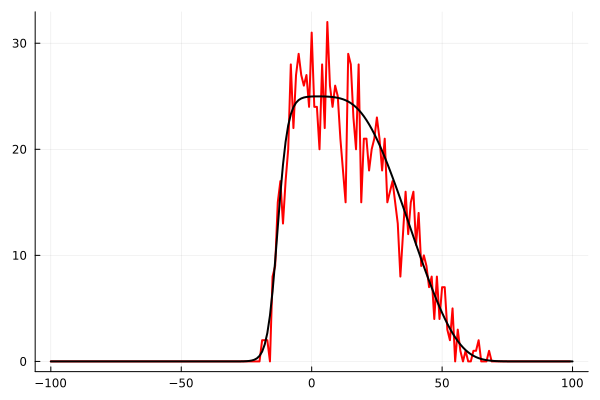

In [9]:
@time (data0,data,pos0,pos)=Stochastic(LX,LY,T,A0,PM,ρ);  #Calls the stochastic model, data below is the output used for reproducibility

data0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 24.0, 15.0, 21.0, 26.0, 32.0, 27.0, 27.0, 20.0, 23.0, 19.0, 31.0, 30.0, 26.0, 26.0, 25.0, 21.0, 31.0, 30.0, 21.0, 23.0, 28.0, 28.0, 24.0, 26.0, 25.0, 20.0, 36.0, 20.0, 30.0, 24.0, 25.0, 17.0, 22.0, 27.0, 28.0, 20.0, 25.0, 26.0, 22.0, 24.0, 20.0, 27.0, 28.0, 19.0, 22.0, 21.0, 22.0, 23.0, 22.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0];
data =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 8.0, 9.0, 15.0, 17.0, 13.0, 17.0, 20.0, 28.0, 22.0, 27.0, 29.0, 27.0, 26.0, 27.0, 24.0, 31.0, 24.0, 24.0, 20.0, 28.0, 22.0, 32.0, 26.0, 24.0, 26.0, 25.0, 21.0, 18.0, 15.0, 29.0, 28.0, 23.0, 20.0, 28.0, 15.0, 21.0, 21.0, 18.0, 20.0, 21.0, 23.0, 21.0, 18.0, 21.0, 15.0, 16.0, 17.0, 15.0, 13.0, 8.0, 12.0, 16.0, 12.0, 15.0, 16.0, 11.0, 14.0, 9.0, 10.0, 9.0, 7.0, 8.0, 4.0, 8.0, 4.0, 7.0, 7.0, 3.0, 2.0, 5.0, 0.0, 3.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0];
pos0 =  [(76, 1), (76, 4), (76, 6), (76, 7), (76, 8), (76, 11), (76, 13), (76, 15), (76, 19), (76, 20), (76, 21), (76, 22), (76, 23), (76, 25), (76, 26), (76, 27), (76, 30), (76, 34), (76, 35), (76, 38), (76, 40), (76, 41), (76, 42), (76, 44), (76, 45), (76, 46), (76, 48), (76, 50), (77, 1), (77, 6), (77, 9), (77, 12), (77, 13), (77, 17), (77, 19), (77, 21), (77, 23), (77, 24), (77, 25), (77, 26), (77, 29), (77, 30), (77, 32), (77, 36), (77, 37), (77, 38), (77, 39), (77, 40), (77, 41), (77, 43), (77, 46), (77, 49), (78, 4), (78, 6), (78, 8), (78, 9), (78, 13), (78, 15), (78, 16), (78, 17), (78, 18), (78, 22), (78, 31), (78, 32), (78, 33), (78, 40), (78, 45), (79, 5), (79, 7), (79, 8), (79, 13), (79, 14), (79, 15), (79, 16), (79, 18), (79, 19), (79, 20), (79, 22), (79, 24), (79, 26), (79, 30), (79, 33), (79, 34), (79, 35), (79, 36), (79, 44), (79, 46), (79, 48), (80, 1), (80, 4), (80, 5), (80, 7), (80, 8), (80, 9), (80, 10), (80, 12), (80, 14), (80, 16), (80, 18), (80, 19), (80, 20), (80, 23), (80, 24), (80, 25), (80, 28), (80, 29), (80, 30), (80, 32), (80, 33), (80, 36), (80, 39), (80, 46), (80, 47), (80, 49), (81, 1), (81, 2), (81, 3), (81, 4), (81, 5), (81, 7), (81, 8), (81, 9), (81, 15), (81, 16), (81, 18), (81, 20), (81, 21), (81, 22), (81, 24), (81, 25), (81, 26), (81, 28), (81, 30), (81, 32), (81, 34), (81, 35), (81, 36), (81, 38), (81, 40), (81, 41), (81, 42), (81, 43), (81, 46), (81, 47), (81, 49), (81, 50), (82, 2), (82, 4), (82, 5), (82, 9), (82, 10), (82, 12), (82, 14), (82, 19), (82, 22), (82, 24), (82, 26), (82, 28), (82, 29), (82, 30), (82, 31), (82, 33), (82, 34), (82, 36), (82, 38), (82, 40), (82, 41), (82, 42), (82, 43), (82, 45), (82, 46), (82, 47), (82, 48), (83, 2), (83, 3), (83, 5), (83, 6), (83, 8), (83, 11), (83, 14), (83, 15), (83, 17), (83, 18), (83, 20), (83, 21), (83, 25), (83, 26), (83, 28), (83, 30), (83, 31), (83, 32), (83, 33), (83, 34), (83, 35), (83, 36), (83, 37), (83, 39), (83, 40), (83, 45), (83, 46), (84, 1), (84, 4), (84, 17), (84, 19), (84, 21), (84, 23), (84, 25), (84, 26), (84, 27), (84, 28), (84, 32), (84, 35), (84, 39), (84, 40), (84, 41), (84, 43), (84, 46), (84, 48), (84, 49), (84, 50), (85, 9), (85, 10), (85, 12), (85, 13), (85, 14), (85, 18), (85, 20), (85, 23), (85, 24), (85, 25), (85, 26), (85, 27), (85, 28), (85, 31), (85, 32), (85, 39), (85, 41), (85, 42), (85, 43), (85, 44), (85, 46), (85, 48), (85, 49), (86, 2), (86, 3), (86, 9), (86, 14), (86, 16), (86, 22), (86, 23), (86, 25), (86, 26), (86, 29), (86, 30), (86, 33), (86, 34), (86, 35), (86, 40), (86, 41), (86, 42), (86, 47), (86, 48), (87, 1), (87, 2), (87, 4), (87, 5), (87, 9), (87, 10), (87, 13), (87, 15), (87, 17), (87, 19), (87, 20), (87, 22), (87, 26), (87, 27), (87, 28), (87, 29), (87, 30), (87, 31), (87, 34), (87, 36), (87, 37), (87, 38), (87, 39), (87, 40), (87, 41), (87, 42), (87, 43), (87, 45), (87, 46), (87, 47), (87, 49), (88, 1), (88, 4), (88, 5), (88, 7), (88, 8), (88, 9), (88, 12), (88, 14), (88, 16), (88, 17), (88, 19), (88, 22), (88, 25), (88, 26), (88, 27), (88, 28), (88, 29), (88, 31), (88, 32), (88, 33), (88, 35), (88, 36), (88, 37), (88, 40), (88, 44), (88, 45), (88, 46), (88, 47), (88, 49), (88, 50), (89, 1), (89, 3), (89, 5), (89, 6), (89, 10), (89, 11), (89, 14), (89, 17), (89, 20), (89, 23), (89, 24), (89, 25), (89, 30), (89, 31), (89, 33), (89, 34), (89, 37), (89, 38), (89, 39), (89, 40), (89, 41), (89, 42), (89, 44), (89, 45), (89, 46), (89, 49), (90, 2), (90, 3), (90, 5), (90, 7), (90, 8), (90, 9), (90, 11), (90, 13), (90, 14), (90, 17), (90, 18), (90, 20), (90, 21), (90, 22), (90, 24), (90, 32), (90, 34), (90, 35), (90, 36), (90, 37), (90, 38), (90, 39), (90, 40), (90, 41), (90, 44), (90, 45), (91, 3), (91, 6), (91, 7), (91, 9), (91, 10), (91, 14), (91, 15), (91, 18), (91, 19), (91, 21), (91, 24), (91, 25), (91, 26), (91, 30), (91, 31), (91, 32), (91, 33), (91, 34), (91, 37), (91, 38), (91, 40), (91, 41), (91, 46), (91, 48), (91, 49), (92, 5), (92, 8), (92, 11), (92, 12), (92, 13), (92, 15), (92, 17), (92, 18), (92, 19), (92, 23), (92, 24), (92, 26), (92, 27), (92, 31), (92, 32), (92, 33), (92, 40), (92, 41), (92, 44), (92, 45), (92, 47), (93, 1), (93, 2), (93, 3), (93, 5), (93, 6), (93, 8), (93, 9), (93, 10), (93, 11), (93, 13), (93, 14), (93, 16), (93, 18), (93, 20), (93, 21), (93, 22), (93, 28), (93, 29), (93, 30), (93, 32), (93, 34), (93, 36), (93, 39), (93, 41), (93, 43), (93, 44), (93, 46), (93, 47), (93, 48), (93, 49), (93, 50), (94, 1), (94, 2), (94, 3), (94, 5), (94, 6), (94, 8), (94, 9), (94, 10), (94, 11), (94, 13), (94, 14), (94, 17), (94, 18), (94, 21), (94, 22), (94, 24), (94, 25), (94, 26), (94, 27), (94, 29), (94, 30), (94, 34), (94, 35), (94, 38), (94, 41), (94, 42), (94, 43), (94, 44), (94, 47), (94, 50), (95, 1), (95, 3), (95, 4), (95, 5), (95, 6), (95, 7), (95, 8), (95, 10), (95, 20), (95, 23), (95, 25), (95, 27), (95, 31), (95, 32), (95, 33), (95, 35), (95, 36), (95, 37), (95, 39), (95, 49), (95, 50), (96, 1), (96, 2), (96, 4), (96, 5), (96, 6), (96, 7), (96, 8), (96, 10), (96, 13), (96, 17), (96, 18), (96, 22), (96, 23), (96, 25), (96, 26), (96, 30), (96, 33), (96, 34), (96, 38), (96, 43), (96, 45), (96, 47), (96, 50), (97, 2), (97, 3), (97, 6), (97, 7), (97, 8), (97, 9), (97, 10), (97, 12), (97, 13), (97, 17), (97, 18), (97, 19), (97, 20), (97, 22), (97, 23), (97, 26), (97, 27), (97, 28), (97, 29), (97, 32), (97, 34), (97, 38), (97, 41), (97, 42), (97, 43), (97, 45), (97, 46), (97, 47), (98, 3), (98, 5), (98, 6), (98, 7), (98, 8), (98, 12), (98, 13), (98, 14), (98, 15), (98, 16), (98, 19), (98, 20), (98, 21), (98, 25), (98, 28), (98, 30), (98, 33), (98, 36), (98, 38), (98, 39), (98, 40), (98, 41), (98, 43), (98, 44), (98, 45), (98, 46), (98, 48), (98, 50), (99, 2), (99, 5), (99, 7), (99, 16), (99, 17), (99, 18), (99, 19), (99, 20), (99, 24), (99, 25), (99, 26), (99, 27), (99, 28), (99, 31), (99, 32), (99, 34), (99, 36), (99, 37), (99, 39), (99, 40), (99, 42), (99, 43), (99, 44), (99, 45), (100, 2), (100, 5), (100, 6), (100, 7), (100, 8), (100, 11), (100, 14), (100, 15), (100, 16), (100, 18), (100, 19), (100, 20), (100, 22), (100, 23), (100, 25), (100, 27), (100, 28), (100, 29), (100, 32), (100, 35), (100, 40), (100, 43), (100, 44), (100, 45), (100, 46), (100, 47), (101, 2), (101, 3), (101, 6), (101, 7), (101, 8), (101, 11), (101, 12), (101, 14), (101, 16), (101, 17), (101, 18), (101, 20), (101, 24), (101, 25), (101, 26), (101, 28), (101, 29), (101, 30), (101, 35), (101, 37), (101, 42), (101, 44), (101, 45), (101, 48), (101, 50), (102, 1), (102, 2), (102, 4), (102, 7), (102, 8), (102, 9), (102, 17), (102, 19), (102, 22), (102, 26), (102, 27), (102, 28), (102, 29), (102, 31), (102, 32), (102, 33), (102, 36), (102, 45), (102, 48), (102, 50), (103, 1), (103, 3), (103, 4), (103, 5), (103, 6), (103, 7), (103, 8), (103, 9), (103, 10), (103, 11), (103, 12), (103, 14), (103, 15), (103, 17), (103, 19), (103, 20), (103, 21), (103, 22), (103, 23), (103, 24), (103, 25), (103, 26), (103, 27), (103, 28), (103, 29), (103, 31), (103, 36), (103, 40), (103, 41), (103, 42), (103, 43), (103, 45), (103, 46), (103, 47), (103, 48), (103, 50), (104, 1), (104, 2), (104, 5), (104, 7), (104, 14), (104, 15), (104, 17), (104, 22), (104, 24), (104, 25), (104, 27), (104, 30), (104, 32), (104, 34), (104, 38), (104, 40), (104, 46), (104, 47), (104, 49), (104, 50), (105, 2), (105, 3), (105, 5), (105, 6), (105, 7), (105, 8), (105, 10), (105, 11), (105, 13), (105, 14), (105, 16), (105, 20), (105, 21), (105, 22), (105, 23), (105, 25), (105, 26), (105, 28), (105, 30), (105, 31), (105, 33), (105, 34), (105, 35), (105, 37), (105, 38), (105, 39), (105, 40), (105, 41), (105, 45), (105, 50), (106, 3), (106, 7), (106, 11), (106, 12), (106, 14), (106, 15), (106, 16), (106, 17), (106, 19), (106, 20), (106, 24), (106, 25), (106, 26), (106, 27), (106, 30), (106, 31), (106, 34), (106, 36), (106, 37), (106, 39), (106, 41), (106, 43), (106, 45), (106, 50), (107, 1), (107, 2), (107, 4), (107, 8), (107, 9), (107, 10), (107, 11), (107, 12), (107, 15), (107, 17), (107, 21), (107, 22), (107, 24), (107, 25), (107, 29), (107, 31), (107, 32), (107, 34), (107, 35), (107, 39), (107, 42), (107, 43), (107, 45), (107, 46), (107, 50), (108, 1), (108, 2), (108, 4), (108, 9), (108, 10), (108, 12), (108, 14), (108, 23), (108, 26), (108, 28), (108, 31), (108, 35), (108, 43), (108, 45), (108, 47), (108, 48), (108, 50), (109, 1), (109, 3), (109, 4), (109, 6), (109, 9), (109, 10), (109, 13), (109, 14), (109, 16), (109, 17), (109, 19), (109, 23), (109, 30), (109, 31), (109, 32), (109, 34), (109, 36), (109, 37), (109, 41), (109, 43), (109, 47), (109, 48), (110, 5), (110, 7), (110, 9), (110, 10), (110, 12), (110, 13), (110, 14), (110, 15), (110, 16), (110, 17), (110, 21), (110, 22), (110, 24), (110, 25), (110, 29), (110, 30), (110, 32), (110, 34), (110, 39), (110, 40), (110, 42), (110, 43), (110, 44), (110, 46), (110, 47), (110, 49), (110, 50), (111, 2), (111, 5), (111, 6), (111, 9), (111, 14), (111, 16), (111, 17), (111, 18), (111, 19), (111, 20), (111, 23), (111, 24), (111, 25), (111, 27), (111, 30), (111, 31), (111, 32), (111, 33), (111, 35), (111, 36), (111, 37), (111, 38), (111, 40), (111, 41), (111, 45), (111, 47), (111, 49), (111, 50), (112, 1), (112, 7), (112, 13), (112, 14), (112, 19), (112, 24), (112, 26), (112, 27), (112, 28), (112, 29), (112, 30), (112, 31), (112, 34), (112, 36), (112, 38), (112, 39), (112, 40), (112, 41), (112, 47), (112, 48), (113, 1), (113, 2), (113, 3), (113, 4), (113, 5), (113, 8), (113, 9), (113, 10), (113, 11), (113, 14), (113, 16), (113, 17), (113, 24), (113, 25), (113, 26), (113, 27), (113, 30), (113, 33), (113, 34), (113, 35), (113, 36), (113, 40), (113, 42), (113, 44), (113, 46), (114, 1), (114, 2), (114, 3), (114, 4), (114, 5), (114, 6), (114, 7), (114, 8), (114, 13), (114, 14), (114, 15), (114, 18), (114, 19), (114, 20), (114, 22), (114, 23), (114, 25), (114, 28), (114, 31), (114, 33), (114, 34), (114, 36), (114, 38), (114, 40), (114, 43), (114, 44), (115, 2), (115, 4), (115, 5), (115, 7), (115, 8), (115, 11), (115, 16), (115, 17), (115, 19), (115, 21), (115, 22), (115, 27), (115, 29), (115, 33), (115, 35), (115, 41), (115, 43), (115, 44), (115, 45), (115, 48), (115, 49), (115, 50), (116, 1), (116, 3), (116, 4), (116, 5), (116, 7), (116, 8), (116, 12), (116, 13), (116, 16), (116, 17), (116, 19), (116, 21), (116, 23), (116, 24), (116, 28), (116, 29), (116, 31), (116, 33), (116, 35), (116, 36), (116, 41), (116, 42), (116, 47), (116, 48), (117, 1), (117, 4), (117, 5), (117, 11), (117, 12), (117, 16), (117, 19), (117, 21), (117, 24), (117, 25), (117, 26), (117, 27), (117, 28), (117, 29), (117, 33), (117, 35), (117, 37), (117, 39), (117, 40), (117, 48), (118, 1), (118, 2), (118, 8), (118, 9), (118, 11), (118, 12), (118, 13), (118, 15), (118, 16), (118, 18), (118, 19), (118, 20), (118, 23), (118, 26), (118, 27), (118, 28), (118, 34), (118, 37), (118, 38), (118, 39), (118, 41), (118, 42), (118, 44), (118, 45), (118, 46), (118, 47), (118, 48), (119, 2), (119, 5), (119, 6), (119, 9), (119, 11), (119, 12), (119, 17), (119, 18), (119, 21), (119, 23), (119, 24), (119, 27), (119, 28), (119, 30), (119, 31), (119, 32), (119, 34), (119, 35), (119, 36), (119, 40), (119, 41), (119, 43), (119, 44), (119, 45), (119, 46), (119, 48), (119, 49), (119, 50), (120, 2), (120, 4), (120, 8), (120, 9), (120, 12), (120, 13), (120, 22), (120, 30), (120, 31), (120, 32), (120, 33), (120, 36), (120, 37), (120, 38), (120, 39), (120, 41), (120, 46), (120, 49), (120, 50), (121, 2), (121, 3), (121, 4), (121, 7), (121, 8), (121, 13), (121, 15), (121, 16), (121, 17), (121, 20), (121, 21), (121, 25), (121, 27), (121, 31), (121, 33), (121, 34), (121, 35), (121, 36), (121, 37), (121, 38), (121, 46), (121, 49), (122, 3), (122, 4), (122, 5), (122, 7), (122, 9), (122, 11), (122, 12), (122, 13), (122, 14), (122, 15), (122, 20), (122, 22), (122, 25), (122, 30), (122, 31), (122, 32), (122, 33), (122, 34), (122, 39), (122, 44), (122, 46), (123, 3), (123, 4), (123, 5), (123, 7), (123, 12), (123, 13), (123, 14), (123, 15), (123, 17), (123, 19), (123, 20), (123, 24), (123, 25), (123, 26), (123, 27), (123, 30), (123, 38), (123, 39), (123, 41), (123, 43), (123, 45), (123, 50), (124, 2), (124, 4), (124, 6), (124, 11), (124, 13), (124, 14), (124, 15), (124, 17), (124, 19), (124, 20), (124, 21), (124, 23), (124, 26), (124, 27), (124, 28), (124, 29), (124, 32), (124, 34), (124, 38), (124, 39), (124, 44), (124, 49), (124, 50), (125, 2), (125, 3), (125, 8), (125, 9), (125, 13), (125, 16), (125, 21), (125, 25), (125, 27), (125, 28), (125, 29), (125, 35), (125, 36), (125, 37), (125, 38), (125, 39), (125, 43), (125, 44), (125, 45), (125, 46), (125, 49), (125, 50), (126, 2), (126, 4), (126, 7), (126, 9), (126, 10), (126, 14), (126, 15), (126, 19), (126, 22), (126, 23), (126, 24), (126, 26), (126, 28), (126, 29), (126, 31), (126, 33), (126, 34), (126, 36), (126, 38), (126, 40), (126, 41), (126, 48), (126, 49), (126, 50)];
pos =   [(82, 25), (82, 40), (83, 43), (83, 44), (84, 3), (84, 45), (86, 10), (86, 19), (86, 24), (86, 25), (86, 35), (86, 38), (86, 42), (86, 48), (87, 9), (87, 10), (87, 19), (87, 20), (87, 22), (87, 26), (87, 30), (87, 35), (87, 46), (88, 6), (88, 11), (88, 12), (88, 17), (88, 22), (88, 25), (88, 27), (88, 28), (88, 31), (88, 32), (88, 33), (88, 34), (88, 37), (88, 39), (88, 48), (89, 1), (89, 2), (89, 4), (89, 5), (89, 12), (89, 13), (89, 14), (89, 17), (89, 20), (89, 21), (89, 25), (89, 27), (89, 31), (89, 38), (89, 45), (89, 46), (89, 48), (90, 18), (90, 24), (90, 25), (90, 26), (90, 30), (90, 31), (90, 34), (90, 36), (90, 38), (90, 40), (90, 43), (90, 45), (90, 46), (91, 2), (91, 4), (91, 5), (91, 7), (91, 8), (91, 20), (91, 21), (91, 22), (91, 25), (91, 26), (91, 27), (91, 31), (91, 37), (91, 38), (91, 45), (91, 46), (91, 49), (92, 1), (92, 3), (92, 4), (92, 5), (92, 7), (92, 9), (92, 11), (92, 13), (92, 15), (92, 17), (92, 21), (92, 27), (92, 28), (92, 29), (92, 30), (92, 31), (92, 33), (92, 34), (92, 41), (92, 49), (93, 1), (93, 2), (93, 3), (93, 4), (93, 5), (93, 8), (93, 9), (93, 11), (93, 13), (93, 18), (93, 21), (93, 22), (93, 25), (93, 27), (93, 28), (93, 29), (93, 30), (93, 31), (93, 35), (93, 38), (93, 39), (93, 41), (93, 42), (93, 45), (93, 46), (93, 48), (93, 49), (93, 50), (94, 1), (94, 5), (94, 8), (94, 9), (94, 10), (94, 14), (94, 18), (94, 19), (94, 21), (94, 22), (94, 25), (94, 26), (94, 27), (94, 28), (94, 29), (94, 31), (94, 33), (94, 36), (94, 38), (94, 39), (94, 44), (94, 47), (95, 4), (95, 5), (95, 7), (95, 9), (95, 10), (95, 12), (95, 15), (95, 18), (95, 21), (95, 22), (95, 26), (95, 27), (95, 28), (95, 30), (95, 31), (95, 33), (95, 34), (95, 35), (95, 37), (95, 38), (95, 40), (95, 41), (95, 42), (95, 45), (95, 46), (95, 49), (95, 50), (96, 2), (96, 3), (96, 4), (96, 5), (96, 6), (96, 8), (96, 9), (96, 11), (96, 12), (96, 13), (96, 14), (96, 15), (96, 17), (96, 18), (96, 21), (96, 22), (96, 25), (96, 26), (96, 27), (96, 29), (96, 30), (96, 32), (96, 33), (96, 34), (96, 38), (96, 39), (96, 40), (96, 44), (96, 49), (97, 1), (97, 2), (97, 3), (97, 5), (97, 6), (97, 7), (97, 8), (97, 9), (97, 10), (97, 17), (97, 20), (97, 24), (97, 25), (97, 30), (97, 31), (97, 32), (97, 33), (97, 35), (97, 39), (97, 41), (97, 42), (97, 43), (97, 44), (97, 45), (97, 47), (97, 48), (97, 50), (98, 1), (98, 6), (98, 7), (98, 10), (98, 12), (98, 13), (98, 15), (98, 19), (98, 20), (98, 21), (98, 23), (98, 27), (98, 29), (98, 30), (98, 31), (98, 32), (98, 34), (98, 35), (98, 36), (98, 39), (98, 40), (98, 43), (98, 45), (98, 48), (98, 49), (98, 50), (99, 1), (99, 3), (99, 6), (99, 7), (99, 9), (99, 10), (99, 11), (99, 12), (99, 17), (99, 20), (99, 21), (99, 24), (99, 31), (99, 32), (99, 33), (99, 34), (99, 35), (99, 36), (99, 38), (99, 39), (99, 40), (99, 41), (99, 42), (99, 43), (99, 45), (99, 47), (99, 50), (100, 1), (100, 3), (100, 4), (100, 7), (100, 8), (100, 9), (100, 10), (100, 12), (100, 15), (100, 16), (100, 18), (100, 19), (100, 22), (100, 23), (100, 27), (100, 28), (100, 31), (100, 34), (100, 35), (100, 39), (100, 42), (100, 44), (100, 45), (100, 46), (101, 1), (101, 2), (101, 6), (101, 7), (101, 10), (101, 12), (101, 13), (101, 14), (101, 15), (101, 16), (101, 18), (101, 19), (101, 21), (101, 22), (101, 23), (101, 27), (101, 29), (101, 32), (101, 33), (101, 34), (101, 37), (101, 38), (101, 39), (101, 40), (101, 41), (101, 42), (101, 44), (101, 45), (101, 46), (101, 47), (101, 50), (102, 3), (102, 5), (102, 7), (102, 8), (102, 9), (102, 10), (102, 12), (102, 13), (102, 14), (102, 15), (102, 16), (102, 17), (102, 18), (102, 27), (102, 30), (102, 31), (102, 32), (102, 34), (102, 35), (102, 36), (102, 40), (102, 45), (102, 46), (102, 50), (103, 2), (103, 3), (103, 4), (103, 5), (103, 6), (103, 12), (103, 13), (103, 17), (103, 18), (103, 19), (103, 21), (103, 22), (103, 24), (103, 26), (103, 27), (103, 29), (103, 32), (103, 33), (103, 37), (103, 40), (103, 42), (103, 43), (103, 46), (103, 47), (104, 1), (104, 3), (104, 4), (104, 5), (104, 6), (104, 11), (104, 13), (104, 14), (104, 15), (104, 17), (104, 18), (104, 20), (104, 25), (104, 26), (104, 29), (104, 30), (104, 31), (104, 38), (104, 42), (104, 45), (105, 4), (105, 7), (105, 8), (105, 9), (105, 11), (105, 12), (105, 14), (105, 16), (105, 17), (105, 18), (105, 19), (105, 21), (105, 22), (105, 23), (105, 24), (105, 25), (105, 26), (105, 27), (105, 30), (105, 32), (105, 35), (105, 36), (105, 40), (105, 41), (105, 42), (105, 43), (105, 44), (105, 47), (106, 1), (106, 5), (106, 7), (106, 8), (106, 12), (106, 16), (106, 19), (106, 21), (106, 23), (106, 25), (106, 27), (106, 28), (106, 29), (106, 31), (106, 33), (106, 34), (106, 38), (106, 39), (106, 43), (106, 44), (106, 48), (106, 50), (107, 1), (107, 2), (107, 3), (107, 4), (107, 7), (107, 8), (107, 10), (107, 12), (107, 13), (107, 14), (107, 15), (107, 16), (107, 18), (107, 19), (107, 20), (107, 21), (107, 22), (107, 23), (107, 25), (107, 26), (107, 28), (107, 29), (107, 30), (107, 31), (107, 35), (107, 36), (107, 37), (107, 39), (107, 40), (107, 46), (107, 47), (107, 50), (108, 3), (108, 4), (108, 6), (108, 7), (108, 9), (108, 11), (108, 12), (108, 14), (108, 16), (108, 20), (108, 22), (108, 23), (108, 24), (108, 25), (108, 26), (108, 27), (108, 32), (108, 33), (108, 36), (108, 38), (108, 40), (108, 41), (108, 44), (108, 45), (108, 48), (108, 50), (109, 3), (109, 5), (109, 8), (109, 10), (109, 11), (109, 13), (109, 17), (109, 18), (109, 21), (109, 22), (109, 23), (109, 24), (109, 27), (109, 31), (109, 32), (109, 33), (109, 35), (109, 36), (109, 37), (109, 39), (109, 45), (109, 46), (109, 47), (109, 50), (110, 3), (110, 8), (110, 10), (110, 11), (110, 13), (110, 14), (110, 15), (110, 16), (110, 17), (110, 20), (110, 21), (110, 26), (110, 27), (110, 29), (110, 30), (110, 34), (110, 35), (110, 36), (110, 38), (110, 41), (110, 43), (110, 44), (110, 45), (110, 46), (110, 48), (110, 49), (111, 2), (111, 4), (111, 8), (111, 10), (111, 12), (111, 13), (111, 14), (111, 16), (111, 20), (111, 21), (111, 22), (111, 25), (111, 26), (111, 28), (111, 32), (111, 34), (111, 35), (111, 36), (111, 38), (111, 39), (111, 42), (111, 43), (111, 46), (111, 47), (111, 49), (112, 5), (112, 6), (112, 7), (112, 8), (112, 10), (112, 11), (112, 12), (112, 13), (112, 18), (112, 20), (112, 21), (112, 23), (112, 25), (112, 27), (112, 30), (112, 35), (112, 37), (112, 39), (112, 43), (112, 44), (112, 46), (113, 1), (113, 3), (113, 4), (113, 13), (113, 17), (113, 18), (113, 23), (113, 29), (113, 31), (113, 33), (113, 34), (113, 38), (113, 40), (113, 43), (113, 44), (113, 45), (113, 46), (113, 49), (114, 7), (114, 13), (114, 14), (114, 18), (114, 21), (114, 23), (114, 25), (114, 26), (114, 28), (114, 32), (114, 34), (114, 39), (114, 40), (114, 42), (114, 43), (115, 1), (115, 2), (115, 3), (115, 6), (115, 8), (115, 9), (115, 10), (115, 11), (115, 12), (115, 14), (115, 16), (115, 17), (115, 19), (115, 20), (115, 22), (115, 23), (115, 25), (115, 26), (115, 28), (115, 33), (115, 35), (115, 36), (115, 39), (115, 40), (115, 41), (115, 42), (115, 43), (115, 44), (115, 46), (116, 2), (116, 5), (116, 6), (116, 7), (116, 11), (116, 14), (116, 15), (116, 17), (116, 19), (116, 20), (116, 21), (116, 22), (116, 23), (116, 24), (116, 25), (116, 29), (116, 30), (116, 34), (116, 35), (116, 37), (116, 38), (116, 42), (116, 43), (116, 46), (116, 47), (116, 48), (116, 49), (116, 50), (117, 2), (117, 3), (117, 4), (117, 5), (117, 7), (117, 9), (117, 13), (117, 17), (117, 18), (117, 20), (117, 23), (117, 24), (117, 25), (117, 27), (117, 29), (117, 32), (117, 34), (117, 38), (117, 39), (117, 40), (117, 48), (117, 49), (117, 50), (118, 2), (118, 3), (118, 4), (118, 7), (118, 16), (118, 17), (118, 20), (118, 21), (118, 22), (118, 25), (118, 26), (118, 27), (118, 32), (118, 33), (118, 35), (118, 38), (118, 41), (118, 46), (118, 47), (118, 49), (119, 1), (119, 3), (119, 4), (119, 6), (119, 7), (119, 8), (119, 9), (119, 10), (119, 11), (119, 12), (119, 13), (119, 15), (119, 16), (119, 20), (119, 22), (119, 23), (119, 24), (119, 34), (119, 35), (119, 36), (119, 37), (119, 38), (119, 40), (119, 42), (119, 46), (119, 47), (119, 48), (119, 50), (120, 6), (120, 15), (120, 17), (120, 23), (120, 27), (120, 29), (120, 30), (120, 31), (120, 33), (120, 38), (120, 42), (120, 43), (120, 44), (120, 46), (120, 48), (121, 1), (121, 2), (121, 10), (121, 12), (121, 13), (121, 15), (121, 16), (121, 21), (121, 23), (121, 29), (121, 31), (121, 32), (121, 36), (121, 37), (121, 39), (121, 41), (121, 42), (121, 43), (121, 45), (121, 47), (121, 50), (122, 3), (122, 4), (122, 7), (122, 9), (122, 11), (122, 13), (122, 14), (122, 18), (122, 19), (122, 20), (122, 21), (122, 22), (122, 25), (122, 28), (122, 32), (122, 33), (122, 34), (122, 35), (122, 37), (122, 49), (122, 50), (123, 2), (123, 7), (123, 8), (123, 11), (123, 12), (123, 18), (123, 20), (123, 23), (123, 24), (123, 28), (123, 29), (123, 30), (123, 33), (123, 40), (123, 41), (123, 43), (123, 44), (123, 45), (124, 1), (124, 3), (124, 4), (124, 6), (124, 7), (124, 8), (124, 9), (124, 10), (124, 12), (124, 14), (124, 15), (124, 18), (124, 24), (124, 26), (124, 29), (124, 35), (124, 36), (124, 41), (124, 42), (124, 48), (125, 1), (125, 3), (125, 6), (125, 11), (125, 15), (125, 18), (125, 19), (125, 27), (125, 32), (125, 33), (125, 34), (125, 35), (125, 37), (125, 38), (125, 39), (125, 41), (125, 42), (125, 44), (125, 47), (125, 49), (125, 50), (126, 3), (126, 4), (126, 5), (126, 7), (126, 10), (126, 11), (126, 12), (126, 14), (126, 19), (126, 20), (126, 24), (126, 25), (126, 27), (126, 28), (126, 29), (126, 32), (126, 36), (126, 43), (126, 44), (126, 45), (126, 47), (126, 49), (126, 50), (127, 3), (127, 5), (127, 8), (127, 11), (127, 12), (127, 13), (127, 18), (127, 20), (127, 22), (127, 24), (127, 25), (127, 29), (127, 32), (127, 33), (127, 35), (127, 36), (127, 37), (127, 39), (127, 42), (127, 47), (127, 48), (128, 5), (128, 8), (128, 10), (128, 12), (128, 13), (128, 15), (128, 24), (128, 25), (128, 27), (128, 31), (128, 32), (128, 34), (128, 36), (128, 41), (128, 42), (128, 46), (128, 48), (128, 50), (129, 1), (129, 5), (129, 7), (129, 8), (129, 12), (129, 19), (129, 21), (129, 23), (129, 26), (129, 27), (129, 29), (129, 31), (129, 32), (129, 33), (129, 34), (129, 37), (129, 38), (129, 40), (129, 41), (129, 47), (129, 48), (130, 3), (130, 5), (130, 9), (130, 14), (130, 17), (130, 18), (130, 19), (130, 25), (130, 27), (130, 28), (130, 33), (130, 34), (130, 36), (130, 38), (130, 48), (131, 1), (131, 2), (131, 5), (131, 6), (131, 8), (131, 9), (131, 19), (131, 21), (131, 25), (131, 27), (131, 28), (131, 31), (131, 32), (131, 39), (131, 41), (131, 47), (132, 3), (132, 7), (132, 9), (132, 12), (132, 13), (132, 14), (132, 16), (132, 17), (132, 18), (132, 20), (132, 23), (132, 29), (132, 31), (132, 36), (132, 39), (132, 41), (132, 44), (133, 2), (133, 3), (133, 8), (133, 9), (133, 11), (133, 20), (133, 23), (133, 34), (133, 35), (133, 36), (133, 37), (133, 38), (133, 45), (133, 48), (133, 49), (134, 6), (134, 10), (134, 12), (134, 13), (134, 17), (134, 20), (134, 28), (134, 32), (134, 34), (134, 36), (134, 42), (134, 43), (134, 50), (135, 4), (135, 13), (135, 21), (135, 25), (135, 27), (135, 35), (135, 43), (135, 50), (136, 5), (136, 8), (136, 12), (136, 17), (136, 24), (136, 27), (136, 29), (136, 30), (136, 36), (136, 37), (136, 38), (136, 39), (137, 1), (137, 3), (137, 6), (137, 7), (137, 15), (137, 16), (137, 18), (137, 22), (137, 23), (137, 24), (137, 30), (137, 36), (137, 38), (137, 39), (137, 44), (137, 46), (138, 7), (138, 10), (138, 15), (138, 16), (138, 17), (138, 27), (138, 28), (138, 29), (138, 37), (138, 38), (138, 43), (138, 46), (139, 3), (139, 4), (139, 6), (139, 7), (139, 13), (139, 22), (139, 24), (139, 25), (139, 29), (139, 38), (139, 39), (139, 41), (139, 45), (139, 46), (139, 47), (140, 1), (140, 5), (140, 7), (140, 10), (140, 17), (140, 20), (140, 25), (140, 27), (140, 31), (140, 33), (140, 37), (140, 40), (140, 41), (140, 43), (140, 48), (140, 49), (141, 1), (141, 6), (141, 11), (141, 16), (141, 20), (141, 21), (141, 27), (141, 28), (141, 33), (141, 45), (141, 50), (142, 5), (142, 6), (142, 10), (142, 15), (142, 16), (142, 18), (142, 19), (142, 23), (142, 26), (142, 27), (142, 32), (142, 46), (142, 47), (142, 48), (143, 13), (143, 19), (143, 20), (143, 24), (143, 37), (143, 38), (143, 43), (143, 45), (143, 48), (144, 8), (144, 11), (144, 15), (144, 18), (144, 23), (144, 28), (144, 31), (144, 37), (144, 44), (144, 50), (145, 1), (145, 3), (145, 4), (145, 17), (145, 29), (145, 33), (145, 39), (145, 45), (145, 47), (146, 10), (146, 13), (146, 17), (146, 22), (146, 23), (146, 36), (146, 43), (147, 3), (147, 9), (147, 11), (147, 14), (147, 20), (147, 24), (147, 43), (147, 48), (148, 11), (148, 23), (148, 33), (148, 37), (149, 7), (149, 8), (149, 17), (149, 30), (149, 32), (149, 40), (149, 45), (149, 50), (150, 6), (150, 28), (150, 35), (150, 36), (151, 7), (151, 10), (151, 21), (151, 22), (151, 29), (151, 31), (151, 41), (152, 7), (152, 13), (152, 14), (152, 16), (152, 21), (152, 41), (152, 43), (153, 1), (153, 16), (153, 42), (154, 14), (154, 46), (155, 2), (155, 17), (155, 36), (155, 40), (155, 44), (157, 6), (157, 18), (157, 27), (158, 32), (160, 37), (163, 34), (164, 46), (165, 25), (165, 39), (169, 20)];

@time numsol=pdesolver(LX,dx,N,T,h,U0,D,v); #Create simple plot to compare stochastic simulation data and PDE solution
p1=plot(xxloc,data,label=false,lw=2,lc=:red)
p1=plot!(-LX/2:dx:LX/2,LY*numsol[:,2],label=false,lw=2,lc=:black)

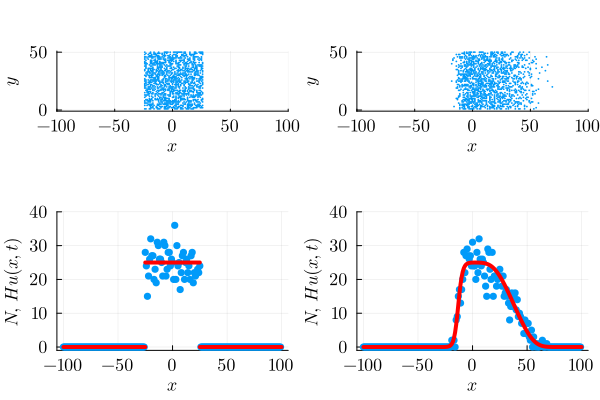

In [10]:
p1 = scatter(pos0[1:end],ms=1,msc=:auto)
p1 = plot!(ylims=(-1,51),xlims=(0,LX), aspect_ratio=:equal,legend=false)
p1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
p1=plot!(xticks=([0, 50, 100, 150, 200],[L"-100", L"-50", L"0", L"50", L"100"]))
p1=plot!(yticks=([0, 50],[L"0",L"50"]))
p1=plot!(xlabel=L"x",ylabel=L"y")
#display(p1)

p2 = scatter(pos[1:end],ms=1,msc=:auto)
p2 = plot!(ylims=(-1,51),xlims=(0,LX), aspect_ratio=:equal,legend=false)
p2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
p2=plot!(xticks=([0, 50, 100, 150, 200],[L"-100", L"-50", L"0", L"50", L"100"]))
p2=plot!(yticks=([0, 50],[L"0",L"50"]))
p2=plot!(xlabel=L"x",ylabel=L"y")
#display(p2)

p3 = scatter(xxloc,data0,label=false,msc=:auto)
f(x)=LY*U0;
g(x)=0.0;
p3=plot!(f,-h,h,lw=4,lc=:red,label=false)
p3=plot!(g,-LX/2,-h,lw=4,lc=:red,label=false)
p3=plot!(g,h,LX/2,lw=4,lc=:red,label=false)
p3=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
p3=plot!(xticks=([-100, -50, 0, 50, 100],[L"-100", L"-50", L"0", L"50", L"100"]))
p3=plot!(yticks=([0,10, 20, 30, 40],[L"0", L"10", L"20", L"30", L"40"]))
p3=plot!(ylims=(-1,40))
p3=plot!(xlabel=L"x",ylabel=L"N, \, H u(x,t)")


p4 = scatter(xxloc,data,label=false,msc=:auto)
p4 = plot!(-LX/2:dx:LX/2,LY*numsol[:,2],lc=:red,lw=4,label=false)
p4=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
p4=plot!(xticks=([-100, -50, 0, 50, 100],[L"-100", L"-50", L"0", L"50", L"100"]))
p4=plot!(yticks=([0,10, 20, 30, 40],[L"0", L"10", L"20", L"30", L"40"]))
p4=plot!(ylims=(-1,40))
p4=plot!(xlabel=L"x",ylabel=L"N, \, H u(x,t)")

p5=plot(p1,p2,p3,p4,layout=(2,2))
#savefig(p5,"dots2.pdf") #Figure 10(e)-(h)
display(p5)

In [11]:
a=zeros(4)  #function to call loglikelihood for NLopt
function funmle(a)
return loglhood(data,a)
end;

  1.161518 seconds (2.30 M allocations: 138.009 MiB, 3.65% gc time, 86.57% compilation time)


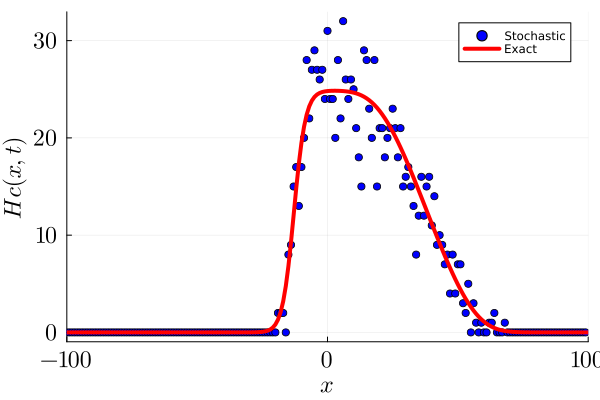

In [12]:
θG=[0.5,0.25,0.25,1.0]
lb=[0.1,0.1,-1.0,0.1]
ub=[1.0,2.0,1.0,10]
@time (xopt,fopt)=Optimise(funmle,θG,lb,ub)
Umle=xopt[1]
Dmle=xopt[2]
vmle=xopt[3]
σmle=xopt[4]
fmle=fopt
numsol=pdesolver(LX,dx,N,T,h,Umle,Dmle,vmle);
p1=scatter(xxloc,data,mc=:blue,msc=:match,label="Stochastic")
p1=plot!(-LX/2:dx:LX/2,LY*numsol[:,2],lc=:red,lw=4,label="Exact",xlabel=L"x",ylabel=L"Hc(x,t)",xlims=(-100,100))
p1=plot!(xticks = ([-100,0,100],  [ L"-100", L"0", L"100" ]))
p1=plot!(yticks = ([0,10,20,30],[L"0", L"10", L"20", L"30"]))
p1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)
display(p1) #Computes the MLE and plots data and MLE solution as a visual check

In [13]:
xopt #Print out the MLE

4-element Vector{Float64}:
 0.4975065883793051
 0.29471416622758295
 0.25243714183080035
 1.9739868420704272

In [14]:
df=1
llstar=-quantile(Chisq(df),0.95)/2;  #Compute the asymptotic threshold loglikelihood value

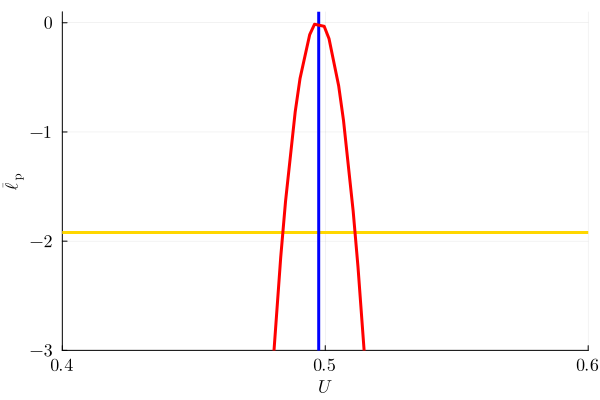

In [15]:
function univariateU(U)  #Compute and plot univariate profile loglikelihood for U
    a=zeros(3)    
    function funU(a)
    return loglhood(data,[U,a[1],a[2],a[3]])
    end
    θG=[Dmle,vmle,σmle]
    lb=[0.1,-1,0.2] 
    ub=[2.0,1,10] 
    (xopt,fopt)=Optimise(funU,θG,lb,ub)
    return fopt,xopt
    end 
    f(x) = univariateU(x)[1]

#Take a grid of M points to plot the univariate profile likelihood
M=50;
Urange=LinRange(0.45,0.54,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariateU(Urange[i])[1]
    #println(i)
end

q1=hline([llstar],legend=false,lw=3,color=:gold)
q1=vline!([Umle],legend=false,xlabel=L"U",ylabel=L"\bar{\ell}_{\textrm{p}}",lw=3,color=:blue)
spl=Spline1D(Urange,ff.-maximum(ff),w=ones(length(Urange)),k=1,bc="nearest",s=1/100)
yy=evaluate(spl,Urange)
q1=plot!(Urange,yy,lw=3,lc=:red,ylims=(-3,0.1),xlims=(0.4,0.6))
q1=plot!(xticks=([0.4,0.5,0.6],[L"0.4", L"0.5", L"0.6"]))
q1=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]))
q1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(q1)

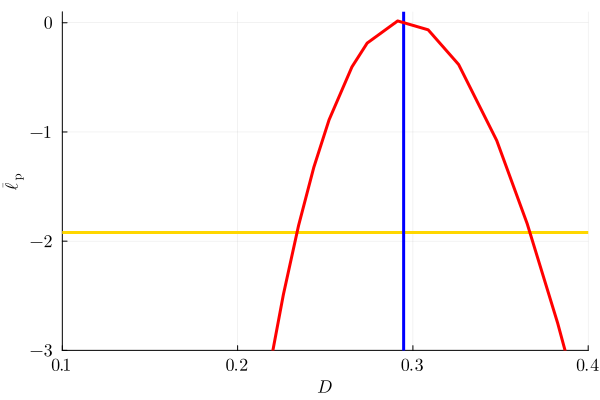

In [16]:
function univariateD(D) #Compute and plot univariate profile loglikelihood for D
    a=zeros(3)    
    function funD(a)
    return loglhood(data,[a[1],D,a[2],a[3]])
    end
    θG=[Umle,vmle,σmle]
    lb=[0.1,-1.0,0.5] 
    ub=[1.0,1.0,5] 
    (xopt,fopt)=Optimise(funD,θG,lb,ub)
    return fopt,xopt
    end 
    f(x) = univariateD(x)[1]

#Take a grid of M points to plot the univariate profile likelihood
M=70;
Drange=LinRange(0.1,0.4,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariateD(Drange[i])[1]
  #  println(i)
end

q2=hline([llstar],legend=false,lw=3,color=:gold)
q2=vline!([Dmle],legend=false,xlabel=L"D",ylabel=L"\bar{\ell}_{\textrm{p}}",lw=3,color=:blue)
spl=Spline1D(Drange,ff.-maximum(ff),w=ones(length(Drange)),k=1,bc="nearest",s=1/100)
yy=evaluate(spl,Drange)
q2=plot!(Drange,yy,lw=3,lc=:red,ylims=(-3,0.1),xlims=(Drange[1],Drange[end]))
q2=plot!(xticks=([0.1,0.2,0.3,0.4],[L"0.1", L"0.2", L"0.3",L"0.4"]))
q2=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]))
q2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(q2)

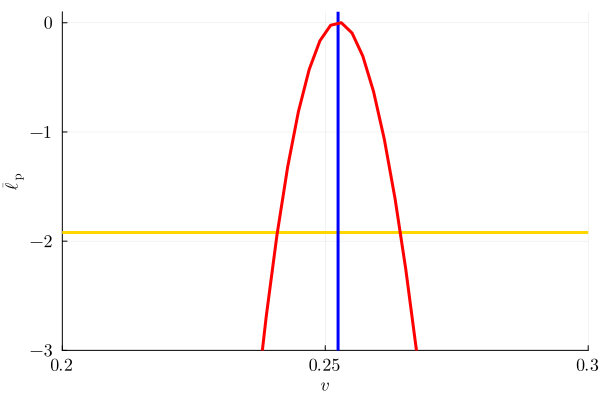

In [17]:
function univariatev(v) #Compute and plot univariate profile loglikelihood for v
    a=zeros(3)    
    function funv(a)
    return loglhood(data,[a[1],a[2],v,a[3]])
    end
    θG=[Umle,Dmle,σmle]
    lb=[0.1,0.1,0.5] 
    ub=[1.0,5.0,5] 
    (xopt,fopt)=Optimise(funv,θG,lb,ub)
    return fopt,xopt
    end 
    f(x) = univariatev(x)[1]

#Take a grid of M points to plot the univariate profile likelihood
M=50;
vrange=LinRange(0.2,0.3,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariatev(vrange[i])[1]
  #  println(i)
end

#q1=scatter(Drange,ff.-maximum(ff),ylims=(-3,0),legend=false,lw=3,color=:blue)
q3=hline([llstar],legend=false,lw=3,color=:gold)
q3=vline!([vmle],legend=false,xlabel=L"v",ylabel=L"\bar{\ell}_{\textrm{p}}",lw=3,color=:blue)
spl=Spline1D(vrange,ff.-maximum(ff),w=ones(length(vrange)),k=1,bc="nearest",s=1/100)
yy=evaluate(spl,vrange)
q3=plot!(vrange,yy,lw=3,lc=:red,ylims=(-3,0.1),xlims=(vrange[1],vrange[end]))
q3=plot!(xticks=([0.2,0.25,0.30],[L"0.2",L"0.25", L"0.3"]))
q3=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]))
q3=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(q3)

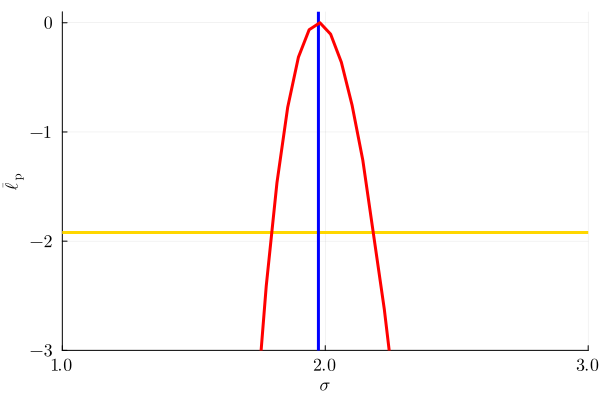

In [18]:
function univariateσ(σ) #Compute and plot univariate profile loglikelihood for σ
    a=zeros(3)    
    function funσ(a)
    return loglhood(data,[a[1],a[2],a[3],σ])
    end
    θG=[Umle,Dmle,vmle]
    lb=[0.1,0.1,-1.0] 
    ub=[1.0,1.0,1.0] 
    (xopt,fopt)=Optimise(funσ,θG,lb,ub)
    return fopt,xopt
    end 
    f(x) = univariateσ(x)[1]

#Take a grid of M points to plot the univariate profile likelihood
M=50;
σrange=LinRange(1.0,3.0,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariateσ(σrange[i])[1]
    #println(i)
end

#q1=scatter(Drange,ff.-maximum(ff),ylims=(-3,0),legend=false,lw=3,color=:blue)
q4=hline([llstar],legend=false,lw=3,color=:gold)
q4=vline!([σmle],legend=false,xlabel=L"σ",ylabel=L"\bar{\ell}_{\textrm{p}}",lw=3,color=:blue)
spl=Spline1D(σrange,ff.-maximum(ff),w=ones(length(σrange)),k=1,bc="nearest",s=1/100)
yy=evaluate(spl,σrange)
q4=plot!(σrange,yy,lw=3,lc=:red,ylims=(-3,0.1),xlims=(σrange[1],σrange[end]))
q4=plot!(xticks=([1.0, 2.0, 3.0],[L"1.0",L"2.0", L"3.0"]))
q4=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]))
q4=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(q4)

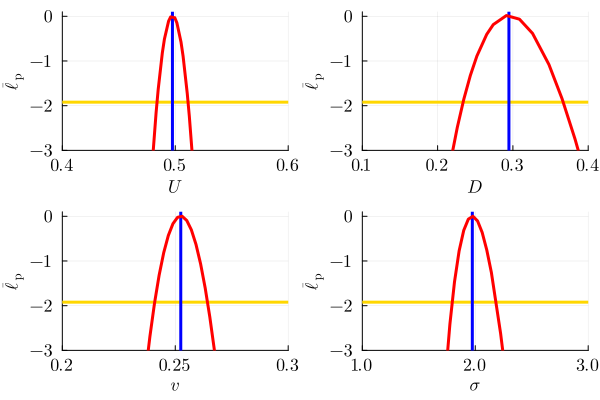

In [19]:
q5=plot(q1,q2,q3,q4,layout=(2,2))
#savefig(q5,"Profiles.pdf") 
display(q5)  #Figure 12(a)

In [20]:
fff(θ1,θ2,θ3,θ4) = funmle([θ1,θ2,θ3,θ4]) #Compute the observed Fisher Information at the MLE
H = -ForwardDiff.hessian(z -> fff(z[1],z[2],z[3],z[4]),xopt);
H = Symmetric(H) #Ensure the matrix is symmetric

4×4 Symmetric{Float64, Matrix{Float64}}:
  35628.9         -2329.53        -20733.9          0.00457793
  -2329.53         1098.72            53.8001      -0.00206063
 -20733.9            53.8001       42326.5         -0.0155501
      0.00457793     -0.00206063      -0.0155501  102.653

In [21]:
Σ = inv(H);
mvnorm = MvNormal(xopt, Σ); #MVN distribution to invoke Laplace's approximation
M=1000
samples = rand(mvnorm, M); #Draw parameter samples

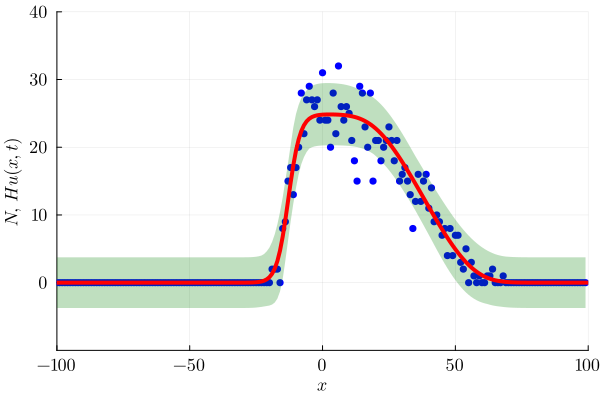

In [22]:
lowerG=2*LY*ones(length(xxloc))
upperG=zeros(length(xxloc))



for i in 1:M
numsol=pdesolver(LX,dx,N,T,h,samples[1,i],samples[2,i],samples[3,i]);
u = linear_interpolation(-LX/2:dx:LX/2,LY.*numsol[:,2]);
    
    for j in 1:length(xxloc)
        if u(xxloc[j])+quantile(Normal(0,samples[4,i]),[0.05,0.95])[1] < lowerG[j] 
            lowerG[j] = u(xxloc[j])+quantile(Normal(0,samples[4,i]),[0.05,0.95])[1]
        end
       
        if u(xxloc[j])+quantile(Normal(0,samples[4,i]),[0.05,0.95])[2] > upperG[j] 
            upperG[j] = u(xxloc[j])+quantile(Normal(0,samples[4,i]),[0.05,0.95])[2] 
        end
       
    end

end


numsol=pdesolver(LX,dx,N,T,h,Umle,Dmle,vmle);
r2=scatter(xxloc,data,mc=:blue,msc=:auto,label=false)
r2=plot!(xxloc,lowerG,lw=0,fillrange=upperG,fillalpha=0.25,color=:green,label=false,xlims=(-100,100),ylims=(-10,40))
r2=plot!(-LX/2:dx:LX/2,LY*numsol[:,2],lw=4,label=false,xlabel=L"x",ylabel=L"N, \, H u(x,t)",color=:red)
r2=plot!(xticks = ([-100,-50,0,50,100],  [L"-100", L"-50", L"0", L"50", L"100"]))
r2=plot!(yticks = ([0,10,20,30,40],[L"0", L"10", L"20", L"30", L"40"]))
r2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(r2) #Figure 12(b)
#savefig(r2,"Predictions.pdf") 